In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, NMF
from keras.models import Sequential
from keras.layers import (
    Input,
    Dense,
    Dropout,
    LeakyReLU,
)
from keras.initializers import glorot_uniform
from keras.optimizers import Adam

In [2]:
# Load data
features = np.load(
    "face_images.npz", allow_pickle=True, fix_imports=True, encoding="latin1"
)
features = features.get(features.files[0])  # images
features = np.moveaxis(features, -1, 0)
features = features.reshape(features.shape[0], features.shape[1], features.shape[1], 1)
keypoints = pd.read_csv("facial_keypoints.csv")

c:\Users\Zain\AppData\Local\Programs\Python\Python310\lib\_collections_abc.py:819: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  return self[key]


In [3]:
# Clean data
keypoints = keypoints.fillna(0)
new_features = features[keypoints.index.values, :, :, :]  # Nums of rows, w, H, Channels
new_features = new_features / 255
keypoints.reset_index(inplace=True, drop=True)

# Split data
x_train, x_test, y_train, y_test = train_test_split(
    new_features, keypoints, test_size=0.2
)

# Flatten and normalize data
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
x_train_flat /= 255.0
x_test_flat /= 255.0

In [4]:
# PCA
pca = PCA(n_components=100)  # Initialize PCA with 100 components
x_train_pca = pca.fit_transform(x_train_flat)  # Fit PCA on training data
x_test_pca = pca.transform(
    x_test_flat
)  # Transform test data using the fitted PCA model

# Custom model for PCA then we densely connect each layer to the next.
# We minimize number of neurons with a non-linear activation function (Leaky ReLU) and dropout regularization to avoid overfitting.
# The output layer has 30 neurons, one for each facial keypoint.
# We use mean squared error as the loss function and Adam as the optimizer.
img_size = 96
model_pca = Sequential()
model_pca.add(Input(shape=(100,)))  # Input layer with 100 dimensions (PCA components)
model_pca.add(
    Dense(256, kernel_initializer=glorot_uniform())
)  # Dense layer with 256 neurons
model_pca.add(LeakyReLU(negative_slope=0.1))  # Leaky ReLU activation function
model_pca.add(Dropout(0.5))  # Dropout regularization
model_pca.add(
    Dense(64, kernel_initializer=glorot_uniform())
)  # Dense layer with 64 neurons
model_pca.add(LeakyReLU(negative_slope=0.1))  # Leaky ReLU activation function
model_pca.add(
    Dense(30, kernel_initializer=glorot_uniform())
)  # Output layer with 30 neurons (facial keypoints)
model_pca.summary()
model_pca.compile(loss="mean_squared_error", optimizer=Adam(), metrics=["accuracy"])

# Train the model with PCA data
BATCH_SIZE = 100
EPOCHS = 50
history_pca = model_pca.fit(
    x_train_pca,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test_pca, y_test),
    shuffle=True,
    verbose=1,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,254 (172.87 KB)

 Trainable params: 44,254 (172.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0048 - loss: 1351.1808 - val_accuracy: 0.0000e+00 - val_loss: 1162.3884
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 6.5580e-05 - loss: 975.4225 - val_accuracy: 0.0099 - val_loss: 507.6289
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0710 - loss: 471.8230 - val_accuracy: 0.8915 - val_loss: 408.9947
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8897 - loss: 420.1264 - val_accuracy: 0.8915 - val_loss: 402.6513
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8887 - loss: 406.9744 - val_accuracy: 0.8915 - val_loss: 399.9327
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9007 - loss: 399.9854 - val_accuracy: 0.8915 - val_loss: 398.9671
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8913 - loss: 402.7189 - val_accuracy: 0.8915 - val_loss: 396.1271
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8906 - loss: 399

In [5]:
# NMF
BATCH_SIZE = 100
EPOCHS = 50
nmf = NMF(
    n_components=100, init="random", random_state=0, max_iter=500
)  # Initialize NMF with 100 components, random initialization, and increased max_iter
x_train_nmf = nmf.fit_transform(x_train_flat)  # Fit NMF on training data
x_test_nmf = nmf.transform(
    x_test_flat
)  # Transform test data using the fitted NMF model

# Model for NMF
model_nmf = Sequential()
model_nmf.add(Input(shape=(100,)))  # Input layer with 100 dimensions (NMF components)
model_nmf.add(
    Dense(256, kernel_initializer=glorot_uniform())
)  # Dense layer with 256 neurons
model_nmf.add(LeakyReLU(negative_slope=0.1))  # Leaky ReLU activation function
model_nmf.add(Dropout(0.5))  # Dropout regularization
model_nmf.add(
    Dense(64, kernel_initializer=glorot_uniform())
)  # Dense layer with 64 neurons
model_nmf.add(LeakyReLU(negative_slope=0.1))  # Leaky ReLU activation function
model_nmf.add(
    Dense(30, kernel_initializer=glorot_uniform())
)  # Output layer with 30 neurons (facial keypoints)
model_nmf.summary()
model_nmf.compile(loss="mean_squared_error", optimizer=Adam(), metrics=["accuracy"])

# Train the model with NMF data
history_nmf = model_nmf.fit(
    x_train_nmf,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test_nmf, y_test),
    shuffle=True,
    verbose=1,
)

c:\Users\Zain\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,254 (172.87 KB)

 Trainable params: 44,254 (172.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0095 - loss: 1351.8046 - val_accuracy: 0.0099 - val_loss: 1159.7715
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0064 - loss: 965.5149 - val_accuracy: 0.0099 - val_loss: 504.3925
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0702 - loss: 472.8831 - val_accuracy: 0.8915 - val_loss: 425.1781
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8854 - loss: 433.4837 - val_accuracy: 0.8915 - val_loss: 421.3273
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8852 - loss: 428.8903 - val_accuracy: 0.8915 - val_loss: 419.4824
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8895 - loss: 432.5735 - val_accuracy: 0.8915 - val_loss: 418.1423
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8894 - loss: 430.0314 - val_accuracy: 0.8915 - val_loss: 416.2530
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8876 - loss: 425.9809 - 

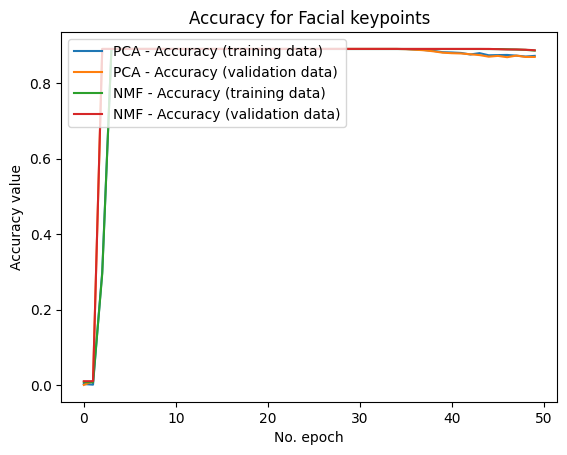

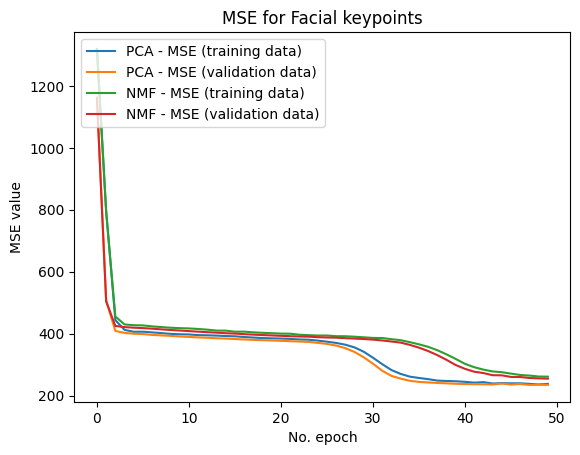

In [6]:
# Plot training history for PCA and NMF
plt.plot(history_pca.history["accuracy"], label="PCA - Accuracy (training data)")
plt.plot(history_pca.history["val_accuracy"], label="PCA - Accuracy (validation data)")
plt.plot(history_nmf.history["accuracy"], label="NMF - Accuracy (training data)")
plt.plot(history_nmf.history["val_accuracy"], label="NMF - Accuracy (validation data)")
plt.title("Accuracy for Facial keypoints")
plt.ylabel("Accuracy value")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()

plt.plot(history_pca.history["loss"], label="PCA - MSE (training data)")
plt.plot(history_pca.history["val_loss"], label="PCA - MSE (validation data)")
plt.plot(history_nmf.history["loss"], label="NMF - MSE (training data)")
plt.plot(history_nmf.history["val_loss"], label="NMF - MSE (validation data)")
plt.title("MSE for Facial keypoints")
plt.ylabel("MSE value")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()